# Modeling-to-Generate-Alternatives (MGA) Tutorial

MGA is commonly used in energy modelling to address what is known as "structural uncertainty."
That is, the uncertainty stemming from unknown, unmodeled, or unmodel-able objectives. For instance,
political feasibility or some other qualitative variable.

## The MGA Idea

To get around this challenge, MGA searches the "sub-optimal" or "near-optimal" region for alternative
solutions by relaxing the objective function. The goal for a single-objective problem is to find 
"maximally different solutions in the design space." In multi-objective problems, specifically ones solved
with genetic algorithms, users can identify alternatives by random selection or farthest first traversal.

This tutorial will illustrate both methods.

## MGA Example \#1

In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# pymoo imports
from pymoo.problems import get_problem
from pymoo.util.plotting import plot
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [8]:
problem = get_problem("bnh")

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False,
               save_history=True
               )

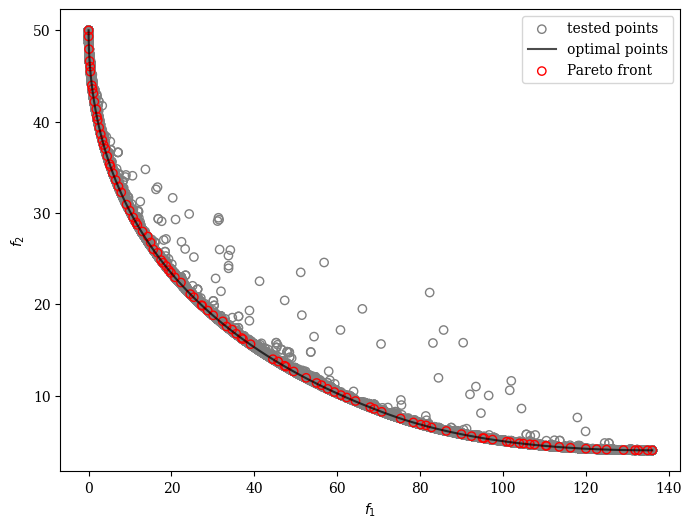

In [13]:
plot = Scatter()
plot.legend = True

for i, history in enumerate(res.history):
    if i == 1:
        plot.add(history.pop.get("F"), facecolor="none", edgecolor='gray', label='tested points') 
    else:
        plot.add(history.pop.get("F"), facecolor="none", edgecolor='gray') 
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7, label='optimal points')
plot.add(res.F, facecolor="none", edgecolor="red", label='Pareto front')
# plot.legend()
plot.show()

In [7]:
N = 1  # the number of different technologies or objectives.
pop_size = 5  # the number of unique individuals.
data = np.c_[[np.arange(pop_size) for i in range(pop_size)]]
display(data)
dist = distance_matrix(data)
display(dist)
points = farthest_first(data, dist, n_points=3, start_idx=0)
points

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_47359/1276232678.py:41: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if mean_distance == prev_mean_dist:


array([3, 0])